In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

import math

from sklearn.metrics import mean_squared_error

import requests

In [22]:
csv_url = 'https://query1.finance.yahoo.com/v7/finance/download/^BSESN?period1=1292716800&period2=1608336000&interval=1d&events=history&includeAdjustedClose=true'
req = requests.get(csv_url)
url_content = req.content
csv_file = open('BSE.csv','wb')

csv_file.write(url_content)
csv_file.close()

In [23]:
df = pd.read_csv('/content/BSE.csv')
df.Close = df.Close.interpolate()

In [24]:
df.Close.isnull().sum()

0

In [25]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-12-20,19770.019531,20006.160156,19711.119141,19888.880859,19888.880859,11200.0
1,2010-12-21,19925.759766,20090.839844,19925.759766,20060.320313,20060.320313,14200.0
2,2010-12-22,20118.820313,20151.250000,19931.310547,20015.800781,20015.800781,12000.0
3,2010-12-23,20038.830078,20076.080078,19939.300781,19982.880859,19982.880859,7600.0
4,2010-12-24,19911.460938,20086.419922,19880.359375,20073.660156,20073.660156,16400.0


In [26]:
df.reset_index()['Close']

0       19888.880859
1       20060.320313
2       20015.800781
3       19982.880859
4       20073.660156
            ...     
2466    46253.460938
2467    46263.171875
2468    46666.460938
2469    46890.339844
2470    46960.691406
Name: Close, Length: 2471, dtype: float64

In [27]:
df1 = df.reset_index()['Close']
df1.head()
type(df1)

pandas.core.series.Series

In [28]:
df1.shape

(2471,)

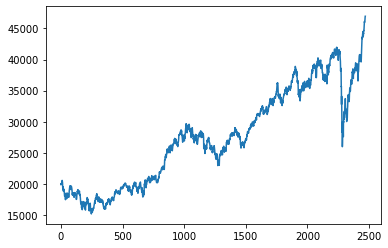

In [29]:
plt.plot(df1)

In [30]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [31]:
training_size = int(len(df1)*0.65)
test_size = int(len(df1)) - training_size
train_data = df1[0:training_size,:]
test_data = df1[training_size:len(df1),:]

In [32]:
train_data.shape

(1606, 1)

In [33]:
test_data.shape

(865, 1)

In [34]:
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i+time_step, 0])
  return np.array(dataX), np.array(dataY)

In [35]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [36]:
X_train

array([[0.14829983, 0.15369345, 0.15229283, ..., 0.1072775 , 0.09943836,
        0.10558863],
       [0.15369345, 0.15229283, 0.15125714, ..., 0.09943836, 0.10558863,
        0.09972906],
       [0.15229283, 0.15125714, 0.15411313, ..., 0.10558863, 0.09972906,
        0.0931953 ],
       ...,
       [0.37943521, 0.38012673, 0.38172994, ..., 0.50610889, 0.50087503,
        0.50112014],
       [0.38012673, 0.38172994, 0.37310655, ..., 0.50087503, 0.50112014,
        0.50276932],
       [0.38172994, 0.37310655, 0.37571276, ..., 0.50112014, 0.50276932,
        0.5002468 ]])

In [37]:
X_test

array([[0.50722476, 0.50678782, 0.50701118, ..., 0.56868026, 0.57068207,
        0.56184159],
       [0.50678782, 0.50701118, 0.50221249, ..., 0.57068207, 0.56184159,
        0.55895703],
       [0.50701118, 0.50221249, 0.49655077, ..., 0.56184159, 0.55895703,
        0.55324905],
       ...,
       [0.72214494, 0.71603626, 0.73359826, ..., 0.96851366, 0.97289089,
        0.97774998],
       [0.71603626, 0.73359826, 0.72032746, ..., 0.97289089, 0.97774998,
        0.97805549],
       [0.73359826, 0.72032746, 0.70978626, ..., 0.97774998, 0.97805549,
        0.99074328]])

In [38]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [40]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=100, batch_size=64, verbose=1
          )

Epoch 1/100
24/24 [==============================] - 11s 59ms/step - loss: 0.0269 - val_loss: 0.0024
Epoch 2/100
24/24 [==============================] - 0s 18ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 3/100
24/24 [==============================] - 0s 18ms/step - loss: 4.8949e-04 - val_loss: 0.0022
Epoch 4/100
24/24 [==============================] - 0s 18ms/step - loss: 3.9877e-04 - val_loss: 0.0021
Epoch 5/100
24/24 [==============================] - 1s 22ms/step - loss: 4.0391e-04 - val_loss: 0.0024
Epoch 6/100
24/24 [==============================] - 0s 18ms/step - loss: 3.7927e-04 - val_loss: 0.0021
Epoch 7/100
24/24 [==============================] - 0s 18ms/step - loss: 3.5145e-04 - val_loss: 0.0023
Epoch 8/100
24/24 [==============================] - 0s 18ms/step - loss: 3.4617e-04 - val_loss: 0.0021
Epoch 9/100
24/24 [==============================] - 0s 18ms/step - loss: 3.5424e-04 - val_loss: 0.0021
Epoch 10/100
24/24 [==============================] - 0s 18ms/step - lo

In [43]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [44]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [45]:
math.sqrt(mean_squared_error(y_train, train_predict))

23380.977159989146

In [46]:
math.sqrt(mean_squared_error(y_test, test_predict))

37003.83838226492

In [47]:
a = np.empty_like(df1)
a[:,:] = np.nan
a[100:len(train_predict)+100,:] = train_predict


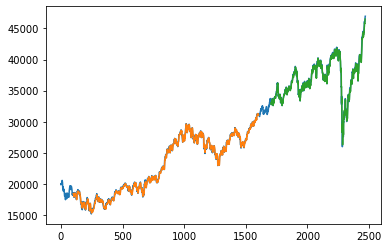

In [48]:
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:] = test_predict

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [49]:
len(test_data)

865

In [50]:
x_input = test_data[765:].reshape(1,-1)
x_input.shape

(1, 100)

In [51]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [52]:
lst_output = []
n_steps = 100
i = 0
while(i<30):
  if(len(temp_input)>100):
    x_input = np.array(temp_input[1:])
    print('{} day input {}'.format(i, x_input))
    x_input = x_input.reshape(1,-1)
    x_input = x_input.reshape((1,n_steps,1))
    yhat = model.predict(x_input, verbose=0)
    print('{} dayoutput {}'.format(i, yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input = temp_input[1:]

    lst_output.extend(yhat.tolist())
    i += 1

  else:
    x_input = x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    lst_output.extend(yhat.tolist())
    i += 1
  
print(lst_output)

[0.9933785]
101
1 day input [0.70572217 0.68472874 0.70827111 0.70749774 0.71889035 0.71936607
 0.72381801 0.7308946  0.72971851 0.7278579  0.71423071 0.71968731
 0.73471106 0.73743144 0.72502335 0.73176628 0.74322931 0.74463878
 0.75187611 0.75312029 0.76425236 0.73785616 0.74642959 0.75225708
 0.74926548 0.72932684 0.73121609 0.72958394 0.72419063 0.74452682
 0.74497453 0.74189383 0.7509458  0.75907842 0.74891658 0.74469986
 0.71916378 0.70972359 0.70765799 0.67258488 0.69885647 0.71751173
 0.71724714 0.72022682 0.74001945 0.74872303 0.7676269  0.77720289
 0.78675825 0.79704014 0.79969268 0.80069033 0.80601433 0.77246682
 0.7804758  0.79458977 0.79813758 0.80326372 0.79858172 0.80257761
 0.78558879 0.79743697 0.77857181 0.77314138 0.7688696  0.77338447
 0.78922656 0.80039551 0.82317372 0.84056834 0.8627284  0.88412861
 0.89407095 0.88663109 0.8893307  0.89734865 0.9053666  0.91251889
 0.89426881 0.90314984 0.9092815  0.92330895 0.90144629 0.91502592
 0.91156462 0.92747505 0.92629834 

In [53]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)

In [54]:
len(df1)

2471

In [55]:
df3 = df1.tolist()
df3.extend(lst_output)

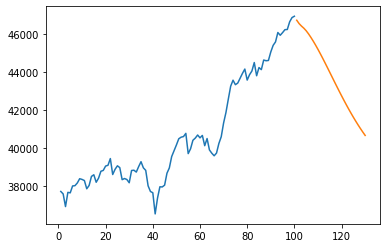

In [57]:
plt.plot(day_new, scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

In [58]:
scaler.inverse_transform(lst_output)

array([[46750.22361668],
       [46573.69894478],
       [46444.04783103],
       [46332.71342074],
       [46196.85190629],
       [46032.1455625 ],
       [45847.76789764],
       [45649.34010113],
       [45438.72832449],
       [45217.2436102 ],
       [44986.62706817],
       [44748.76000647],
       [44505.41574269],
       [44258.2292908 ],
       [44008.73146342],
       [43758.35455554],
       [43508.42855533],
       [43260.15083108],
       [43014.61265515],
       [42772.78215286],
       [42535.49104046],
       [42303.47251657],
       [42077.30821421],
       [41857.49829986],
       [41644.41600385],
       [41438.33224967],
       [41239.43270522],
       [41047.80830984],
       [40863.47232553],
       [40686.3603369 ]])